# Exploratory Data Analysis

- 데이터 전처리
    - 데이터 탐색
    - 데이터 클렌징

In [1]:
%matplotlib inline
pd.options.display.max_columns = 200
from numpy.linalg import svd
from scipy.sparse.linalg import svds
import scipy.sparse as sparse
import surprise
from scipy.sparse.linalg import spsolve
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_action = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv')
df_transaction = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv')
df_client_demo = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv')
df_product = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv')

# Online Action columns
- clnt_id : 클라이언트 ID, 고객을 고유하게 식별할 수 있도록 랜덤으로 부여된 ID
- sess_id : 세션 ID, Web/App에 접속 후 세션이 시작될 때 부여된 순번 ID (클라이언트 ID에 여러개의 세션 ID 발급될 수 있음)
- hit_seq : 조회일련번호, 조회 순서를 알 수 있도록 부여된 일련번호
- action_type : 행동유형, 총 8가지의 행동 유형을 구분한 코드 [0.검색/ 1.제품 목록/ 2.제품 세부정보 보기/ 3. 장바구니 제품 추가/ 4, 장바구니 제품 삭제/ 5. 결제시도/ 6. 구매 완료/ 7. 구매환불/ 8. 결제옵션]
- biz_unit : 업종단위, 온라인 및 오프라인 이용처를 구분하는 단위코드
- sess_dt : 세션일자, (YYYYMMDD 형식)
- hit_tm : 조회시간 (HH:MM 형식)
- hit_pss_tm : 조회경과시간, 세션이 시작된 이후 해당 조회까지 경과한 시간(단위:밀리초), 첫번째 조회하면 0으로 설정
- trans_id : 거래 ID, 구매내역을 고유하게 식별할 수 있도록 랜덤으로 부여된 ID
- srch_kwd : 검색 키워드, 고객이 검색한 키워드
- tot_pag_view_ct : 홈페이지조회건수, 세션 내의 총 페이지(화면)뷰 수
- tot_sess_hr_v : 총세션시간값, 세션 내 총 시간(단위: 초)
- trfc_src : 유입채널, 고객이 유입된 채널, [DIRECT/ PUSH/ WEBSITE/ PORTAL_1/ PORTAL_2/ PORTAL_3/ unknown]
- dvc_ctg_nm : 기기유형, [mobile_web/ mobile_app/ PC]

In [3]:
df_action.tail(10)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3196352,31032,3,5,0,A02,20190805,10:54,47963,NaN,오야니,8.0,356.0,unknown,mobile_app
3196353,31032,2,6,0,A02,20190804,22:37,527684,NaN,오야니,19.0,1047.0,unknown,mobile_app
3196354,31032,2,9,0,A02,20190804,22:41,771472,NaN,오야니,19.0,1047.0,unknown,mobile_app
3196355,31032,2,1,0,A02,20190804,22:35,356864,NaN,양가죽자켓,19.0,1047.0,unknown,mobile_app
3196356,31032,3,1,0,A02,20190805,10:53,8782,NaN,오야니,8.0,356.0,unknown,mobile_app
3196357,31040,1,1,0,A02,20190815,03:47,13525,NaN,다이슨 에어랩,4.0,62.0,unknown,mobile_web
3196358,4129,1,2,0,A02,20190721,01:22,250099,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196359,4129,1,1,0,A02,20190721,01:18,1525,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196360,54403,3,1,0,A02,20190731,20:14,16905,NaN,비비고왕교자,3.0,68.0,unknown,mobile_app
3196361,54403,4,1,0,A02,20190818,16:35,82700,NaN,에포테쉬볼륨팝브러쉬,5.0,101.0,unknown,mobile_app


### Missing Data

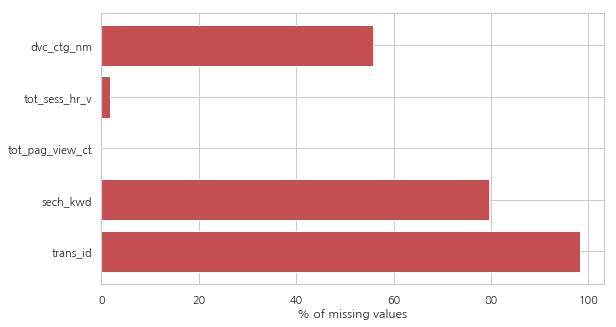

In [4]:
df_missing = df_action.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(9,5))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_action))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

# Transaction columns
- clnt_id : 클라이언트 ID 
- trans_id : 거래 ID
- trans_seq: 거래일련번호, 해당 거래 ID의 구매 내역 내 구매 순서를 알 수 있도록 부여된 일련번호
- biz_unit : 업종단위  
- pd_c : 상품소분류코드,
- de_dt : 상품을 구매한 일자 (YYYYMMDD)
- de_tm : 상품을 구매한 시각 (HH:MM)
- buy_am : 구매한 상품의 금액
- buy_ct : 구매한 상품의 수량

In [5]:
df_transaction.tail(10)

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
599951,2400,4453,2,B03,0313,20190927,11:25,7700,1
599952,28484,13342,1,B03,1060,20190927,15:47,5000,1
599953,54080,2842,2,B03,0339,20190927,16:16,5200,1
599954,54080,2842,1,B03,1066,20190927,16:16,12600,1
599955,35311,2839,1,B03,0339,20190927,14:09,4500,1
599956,35311,2839,3,B03,0339,20190927,14:09,3500,1
599957,35311,2839,4,B03,0339,20190927,14:09,3600,2
599958,35311,2839,5,B03,0339,20190927,14:09,3500,1
599959,35311,2839,2,B03,0339,20190927,14:09,4500,1
599960,35311,2839,6,B03,0324,20190927,14:09,6800,1


In [6]:
df1 = df_transaction[['clnt_id', 'pd_c']]
df1.tail(5)

,clnt_id,pd_c
599956,35311,0339
599957,35311,0339
599958,35311,0339
599959,35311,0339
599960,35311,0324


In [7]:
df1['pd_c'].unique()

array(['unknown', '0565', '0572', ..., '0689', '1078', '0305'],
      dtype=object)

In [8]:
df1.loc[df1['pd_c'] == 'unknown', 'pd_c'] = '0000'

In [9]:
df1['clnt_id'] = df1['clnt_id'].astype(int)
df1['pd_c'] = df1['pd_c'].astype(int)

# Client Demographic
- clnt_id : 클라이언트 ID
- clnt_gender : 성별 [M/F/unknown]
- clnt_age : 연령대 [10대 이하/ 20대/ 30대/ 40대/ 50대/ 60대 이상/ 정보없음 : unknown]

In [10]:
df_client_demo.tail(10)

,clnt_id,clnt_gender,clnt_age
72389,72420,unknown,unknown
72390,72421,unknown,unknown
72391,72422,unknown,unknown
72392,72423,F,30
72393,72424,M,40
72394,72425,unknown,unknown
72395,72426,unknown,unknown
72396,72427,unknown,unknown
72397,72428,unknown,unknown
72398,72429,unknown,unknown


# Product columns
- pd_c : 상품 소분류코드 (최소단위)
- clac_nm1 : 상품 대분류명
- clac_nm2 : 상품 중분류명
- clac_nm3 : 상품 소분류명

In [11]:
df_product.tail(10)

,pd_c,clac_nm1,clac_nm2,clac_nm3
1657,1658,Women's Clothing,Women's Special Use Clothing,Other Women's Special Use Clothing
1658,1659,Women's Clothing,Women's Special Use Clothing,Women's Costumes
1659,1660,Women's Clothing,Women's Special Use Clothing,Women's Fashion Trainingwear
1660,1661,Women's Clothing,Women's Upper Bodywear / Tops,Women's Blouses
1661,1662,Women's Clothing,Women's Upper Bodywear / Tops,Women's Button-Down Shirts
1662,1663,Women's Clothing,Women's Upper Bodywear / Tops,Women's Cardigans
1663,1664,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweaters / Pullover
1664,1665,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweatshirts / Hoodies
1665,1666,Women's Clothing,Women's Upper Bodywear / Tops,Women's T-shirts / Tops
1666,1667,Women's Clothing,Women's Upper Bodywear / Tops,Women's Vests


### Missing Data

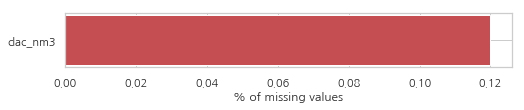

In [12]:
df_missing = df_product.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(8,1))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_product))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

## Latent-factor

In [13]:
df1 = df_transaction[['clnt_id', 'pd_c']]
df1.loc[df1['pd_c'] == 'unknown', 'pd_c'] = '0000'
df1['clnt_id'] = df1['clnt_id'].astype(int)
df1['pd_c'] = df1['pd_c'].astype(int)
df = pd.merge(df1, df_product, how='left')
df2 = df[['clnt_id', 'clac_nm3']]
df3 = df2.groupby(["clnt_id", "clac_nm3"]).size().reset_index(name="Counts")
df4 = df3.pivot_table('Counts', 'clnt_id', 'clac_nm3', fill_value=0)
df4.tail(5)

clac_nm3,,Accessory Bags,Accident Prevention Equipment,Adhesive Tapes,Adhesives,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bed Fillings,Adults' Bedding Sets,Adults' Blankets,Adults' Duvet / Duvet Cover,Adults' Korean Style Mattress / Covers,Adults' Matteress Pads,Adults' Mattress Cover,Adults' Pads / Bed Spread,Adults' Pillow / Pillow Cover,Aekjeot,Air Fresheners,Air Purifiers,Albums,All-In-One Underwear,Almonds,Altari Radishes,Amusement Facilities,Amusement Park Tickets,Anchovies Gift Sets,Anklets,Ant / Cockroach Killers,Apicultural Honey,Apples,Apples Gift Sets,Apricots,Aqua Shoes,Aquarium Bird Accessories,Aquarium Fish,Aquarium Fish Accessories,Aroma Therapy Diffusers,Art / Creative Toys,Artificial Flowers,Artificial Seasonings,Arts / Crafts,Assembly Toys,Assorted Mushrooms,Assorted Sashimi / Sliced Raw Fish,Atka Mackerel,Audio Accessories,Audio Amplifiers / Speakers,Australian Imported Beefs - Bone-in Short Ribs,Australian Imported Beefs - Briskets,Australian Imported Beefs - Chunks,Australian Imported Beefs - Hanging Tenders,Australian Imported Beefs - Outside Skirts,Australian Imported Beefs - Rounds,Australian Imported Beefs - Rumps,Australian Imported Beefs - Shanks,Australian Imported Beefs - Shoulders,Australian Imported Beefs - Sirloins,Australian Imported Beefs - Striploins,Australian Imported Beefs - Tenderloins,Automobile Oil / Additives,Avocados,BB / Face Foundation / Compact Powder,Baby Bath Products,Baby Bath Toys,Baby Beverages,Baby Bodysuits,Baby Bouncers / Saucers / Walkers,Baby Car Seats / Mattress Pads,Baby Carriers,Baby Foods Accessories,Baby Formula,Baby Ginsengs,Baby Health Supplements,Baby Mattress Pads,Baby Potties& Seats / Potty Trainings,Baby Shampoos / Body Washes,Baby Skin Care,Baby Snack Foods,Baby Strollers,Baby Wipes,Backpakcs,Bacons,Badminton Rackets,Badminton Shuttlecocks,Bag Sets,Bakery,Bakery Cakes,Bakery Gift Sets,Bakery Ingredients,Bakery Pastries,Bakery Plain breads,Bakewares,Balloons,Ballpoint Pens,Bananas,Band-Aids,Bar Ice Creams,Barley,Baseball Bats,...,Women's Blouses,Women's Boots,Women's Button-Down Shirts,Women's Cardigans,Women's Casual Sport Socks and Hosiery,Women's Climbing Bodysuits / Dresses,Women's Climbing Clothing Sets,Women's Climbing Jumpers / Jackets,Women's Climbing Paddingwear,Women's Climbing Pants,Women's Climbing T-shirts / Tops,Women's Climbing Vests,Women's Clutch Bags,Women's Coats,Women's Comport Shoes,Women's Costumes,Women's Cross-Body Bags,Women's Dresses,Women's Fashion Sneakers,Women's Fashion Trainingwear,Women's Flats,Women's Flip Flops,Women's Fur Coats,Women's General Socks and Hosiery,Women's General Sport Pants,Women's General Wallets,Women's Gloves,Women's Golf Bodysuits / Dresses,Women's Golf Clothing Sets,Women's Golf Knitwear / Cardigan,Women's Golf Pants,Women's Golf Skirts,Women's Golf T-shirts / Tops,Women's Gowns / Robes,Women's Hair Accessories,Women's Homewears,Women's Jackets,Women's Jeans,Women's Jumpers,Women's Jumpsuits / Overalls,Women's Leather Clothing,Women's Leggings,Women's Liner Socks,Women's Loafer,Women's Paddingwear,Women's Panties,Women's Pants,Women's Perfume Sets,Women's Perfumes,Women's Pumps,Women's Running / Training Shoes,Women's Sandals,Women's Shoes Accessories,Women's Shoulder Bags,Women's Skirts,Women's Sleepwear,Women's Slip-Ons,Women's Slippers,Women's Snow Shoes,Women's Socks and Hosiery Gift Sets,Women's Sport Jumpers / Jackets,Women's Sport Sandals / Slippers,Women's Sport Shoes Accessories,Women's Sport Sweatshirts / Hoodies,Women's Sport T-Shirts / Tops,Women's Sport Underwear,Women's Sunglasses,Women's Sweaters / Pullover,Women's Sweatshirts / Hoodies,Women's Swimwear,Women's T-shirts / Tops,Women's Thermal Underwear,Women's Tights,Women's Totes,Women's Trainingwear,Women's Trench Coats,Women's Undershirts & Camisoles,Women's Underwear Sets,Women's Vests,Women's Watches,Women's' Hipsacks,Work Gloves,Wrapping Vegetables,Writing Boards,Writing Correction Supplies,Writing

### 1.Dataframe convert array 

In [14]:
A = df4.values
A.shape

(11270, 1662)

### 2-1)SVD(Singure Value Decomposition) - Full_matrices
- U : N x N
- S : N x M
- VT : M x M

In [15]:
U, S, VT = svd(A, full_matrices=True)
U.shape, S.shape, VT.shape

((11270, 11270), (1662,), (1662, 1662))

### 2.2)SVD(Singure Value Decomposition) - 축소형
- U : N x N
- S : M x M
- M : M x M

In [16]:
U2, S2, VT2 = svd(A, full_matrices=False)
U2.shape, S2.shape, VT2.shape

((11270, 1662), (1662,), (1662, 1662))

### 2.3)Truncated SVD ; 
- S의 대각 성분은 특이치라고 하며 전체 특이치 중에서 가장 값이 큰 k개의 특이치만을 사용하여 계산한다. 
- $\hat U$ : M X k
- $\hat S$ : k X k
- $\hat V$ : k X N

In [17]:
A = A.astype(float)

- Scipy and Numpy both have functions to do the singular value decomposition. I’m going to use the Scipy function svds because it let’s me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

### 2.4) from scipy.sparse.linalg import svds

In [18]:
U, sigma, Vt = svds(A, k=20)

In [19]:
U.shape, sigma.shape, Vt.shape

((11270, 20), (20,), (20, 1662))

In [21]:
import sklearn
from sklearn.decomposition import TruncatedSVD

df4.tail()

clac_nm3,,Accessory Bags,Accident Prevention Equipment,Adhesive Tapes,Adhesives,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bed Fillings,Adults' Bedding Sets,Adults' Blankets,Adults' Duvet / Duvet Cover,Adults' Korean Style Mattress / Covers,Adults' Matteress Pads,Adults' Mattress Cover,Adults' Pads / Bed Spread,Adults' Pillow / Pillow Cover,Aekjeot,Air Fresheners,Air Purifiers,Albums,All-In-One Underwear,Almonds,Altari Radishes,Amusement Facilities,Amusement Park Tickets,Anchovies Gift Sets,Anklets,Ant / Cockroach Killers,Apicultural Honey,Apples,Apples Gift Sets,Apricots,Aqua Shoes,Aquarium Bird Accessories,Aquarium Fish,Aquarium Fish Accessories,Aroma Therapy Diffusers,Art / Creative Toys,Artificial Flowers,Artificial Seasonings,Arts / Crafts,Assembly Toys,Assorted Mushrooms,Assorted Sashimi / Sliced Raw Fish,Atka Mackerel,Audio Accessories,Audio Amplifiers / Speakers,Australian Imported Beefs - Bone-in Short Ribs,Australian Imported Beefs - Briskets,Australian Imported Beefs - Chunks,Australian Imported Beefs - Hanging Tenders,Australian Imported Beefs - Outside Skirts,Australian Imported Beefs - Rounds,Australian Imported Beefs - Rumps,Australian Imported Beefs - Shanks,Australian Imported Beefs - Shoulders,Australian Imported Beefs - Sirloins,Australian Imported Beefs - Striploins,Australian Imported Beefs - Tenderloins,Automobile Oil / Additives,Avocados,BB / Face Foundation / Compact Powder,Baby Bath Products,Baby Bath Toys,Baby Beverages,Baby Bodysuits,Baby Bouncers / Saucers / Walkers,Baby Car Seats / Mattress Pads,Baby Carriers,Baby Foods Accessories,Baby Formula,Baby Ginsengs,Baby Health Supplements,Baby Mattress Pads,Baby Potties& Seats / Potty Trainings,Baby Shampoos / Body Washes,Baby Skin Care,Baby Snack Foods,Baby Strollers,Baby Wipes,Backpakcs,Bacons,Badminton Rackets,Badminton Shuttlecocks,Bag Sets,Bakery,Bakery Cakes,Bakery Gift Sets,Bakery Ingredients,Bakery Pastries,Bakery Plain breads,Bakewares,Balloons,Ballpoint Pens,Bananas,Band-Aids,Bar Ice Creams,Barley,Baseball Bats,...,Women's Blouses,Women's Boots,Women's Button-Down Shirts,Women's Cardigans,Women's Casual Sport Socks and Hosiery,Women's Climbing Bodysuits / Dresses,Women's Climbing Clothing Sets,Women's Climbing Jumpers / Jackets,Women's Climbing Paddingwear,Women's Climbing Pants,Women's Climbing T-shirts / Tops,Women's Climbing Vests,Women's Clutch Bags,Women's Coats,Women's Comport Shoes,Women's Costumes,Women's Cross-Body Bags,Women's Dresses,Women's Fashion Sneakers,Women's Fashion Trainingwear,Women's Flats,Women's Flip Flops,Women's Fur Coats,Women's General Socks and Hosiery,Women's General Sport Pants,Women's General Wallets,Women's Gloves,Women's Golf Bodysuits / Dresses,Women's Golf Clothing Sets,Women's Golf Knitwear / Cardigan,Women's Golf Pants,Women's Golf Skirts,Women's Golf T-shirts / Tops,Women's Gowns / Robes,Women's Hair Accessories,Women's Homewears,Women's Jackets,Women's Jeans,Women's Jumpers,Women's Jumpsuits / Overalls,Women's Leather Clothing,Women's Leggings,Women's Liner Socks,Women's Loafer,Women's Paddingwear,Women's Panties,Women's Pants,Women's Perfume Sets,Women's Perfumes,Women's Pumps,Women's Running / Training Shoes,Women's Sandals,Women's Shoes Accessories,Women's Shoulder Bags,Women's Skirts,Women's Sleepwear,Women's Slip-Ons,Women's Slippers,Women's Snow Shoes,Women's Socks and Hosiery Gift Sets,Women's Sport Jumpers / Jackets,Women's Sport Sandals / Slippers,Women's Sport Shoes Accessories,Women's Sport Sweatshirts / Hoodies,Women's Sport T-Shirts / Tops,Women's Sport Underwear,Women's Sunglasses,Women's Sweaters / Pullover,Women's Sweatshirts / Hoodies,Women's Swimwear,Women's T-shirts / Tops,Women's Thermal Underwear,Women's Tights,Women's Totes,Women's Trainingwear,Women's Trench Coats,Women's Undershirts & Camisoles,Women's Underwear Sets,Women's Vests,Women's Watches,Women's' Hipsacks,Work Gloves,Wrapping Vegetables,Writing Boards,Writing Correction Supplies,Writing

In [24]:
df4_trans = df4.T
df4_trans.tail(2)

clnt_id,2,9,12,20,23,24,29,38,40,41,43,45,49,54,57,60,64,70,80,92,95,106,124,135,137,151,152,172,176,182,183,185,189,202,211,214,218,226,228,245,247,269,271,275,277,282,285,290,317,321,333,336,343,353,376,377,385,395,416,420,422,434,456,458,459,462,464,475,487,493,507,521,536,538,548,551,577,583,585,588,589,592,608,615,624,625,627,633,635,637,642,650,665,686,690,695,696,706,712,714,...,71775,71792,71794,71797,71821,71823,71856,71865,71873,71876,71896,71897,71903,71916,71918,71932,71939,71940,71944,71949,71958,71959,71984,71995,71996,72004,72005,72007,72020,72022,72023,72031,72035,72044,72046,72048,72053,72054,72061,72062,72067,72073,72077,72078,72091,72092,72093,72095,72097,72105,72107,72108,72125,72131,72133,72147,72153,72160,72167,72176,72185,72186,72189,72190,72193,72198,72199,72206,72209,72216,72221,72226,72228,72237,72238,72239,72244,72246,72249,72250,72254,72258,72267,72270,72284,72287,72297,72301,72321,72331,72333,72340,72342,72356,72361,72373,72400,72410,72423,72424
clac_nm3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
kelp,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
life Vests / Safety Accessories,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
#Substing the data for Product
names_of_prod = df4.columns
list_of_prod = list(names_of_prod)

#### Profiling Matrix Factorization and Recommendation Engines with Python
- https://towardsdatascience.com/profiling-matrix-factorization-and-recommendation-engines-with-python-330c0f35e274
#### Recommender systems in E-Commerce
- http://files.grouplens.org/papers/ec-99.pdf
#### Collaborative Filtering for Implicit Feedback Datasets